## Stable Diffusion Deep Dive

원래 Stable Diffusion은 간단하게 Pipeline 을 활용하여

from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision = "fp16", torch_dtype = torch.float16, use_auth_token = True).to("cuda")

image = pipe("An astronaut scuba Diving").images[0]

이렇게 간단히 할 수 있지만, 그 속의 세부적인 작동을 직접 코드로 구현해보았다.

In [ ]:
!pip install -q --update transformers diffusers ftfy

from huggingface_hub import notebook_login
notebook_login()


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --update


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Stable Diffusion을 구성하는 요소들을 잘 살펴보자

prompt를 토큰으로 각각 처리하기 위해서 transformer에서 CLIP 2개를 불러왔고,

VAE = latent를 실제 이미지로 복원해주는 Autoencoder

Unet도 필요하고, LMSDiscreteScheduler는 timestep마다 update되는 latent를 관리한다.


In [ ]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from transformers import logging # 모델 로딩할 때 경고/정보 메시지가 엄청 많이 뜨는 걸 조절
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm # progressing bar 자동으로 골라줌
from torch import autocast # autocast() 컨텍스트 안에서는 PyTorch가 “적절한 연산만 FP16으로” 자동 변환
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

logging.set_verbosity_error()
torch_device = "cuda"

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "unet")

# beta_start = 시작할 때 노이즈값(깨끗) beta_end = 학습 후 노이즈값
scheduler = LMSDiscreteScheduler(beta_start =0.00085, beta_end = 0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# 다 GPU로 ㄱㄱ
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

### A diffusion Loop

In [ ]:
prompt = ["A watercolor paintings of an cat"]
height = 512
width = 512
num_inference_steps = 30
guidance_scale = 7.5
generator = torch.manual_seed(32)
batch_size = 1

# Prepare Text
# padding은 자릿수만큼 빈 자리 채우기  max_length를 모델이 기대하는 최대길이로 맞춤, truncation = 최대값 넘으면 잘라냄 True, 출력 텐서를 pytorch로 받음
text_input = tokenizer(prompt, padding = "max_length", max_length = tokenizer.model_max_length, truncation = True, return_tensors = "pt")
with torch.no_grad(): # 토큰 id 텐서를 cuda로 올리는 코드, [0]은 last_hidden_state (각 토큰의 임베딩)을 의미
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding = "max_length", return_tensors = "pt")
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Classifier-Free Guidance를 위해서 conditioned embedding과 unconditioned embedding 이렇게 2개로 분리해서 생성해놓는다.

CFG = 프롬프트가 없을 때의 결과와 비교해서 더 프롬프트를 세게 강조하자는 의도로 쓰인다.

uncondition으로 돌린결과와 conditioned로 돌린결과를 뺀 만큼의 차이를 반영하여 더 프롬프트를 강하게 반영하는 쪽으로 진행한다.

In [ ]:
# Prepare Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler,num_inference_steps)


# Prepare Latent
latents = torch.randn(batch_size, unet.in_channels, height // 8, width // 8, generator = generator) # generator는 32번 시드로 고정
latents = latents.to(torch_device) # unet이 input으로 latent받으므로 latent도 gpu에 올려놓기
latents = latents * scheduler.init_noise_sigma # 초기 노이즈 스케일링

/tmp/ipython-input-1340755212.py:10: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn(batch_size, unet.in_channels, height // 8, width // 8, generator = generator) # generator는 32번 시드로 고정


0it [00:00, ?it/s]

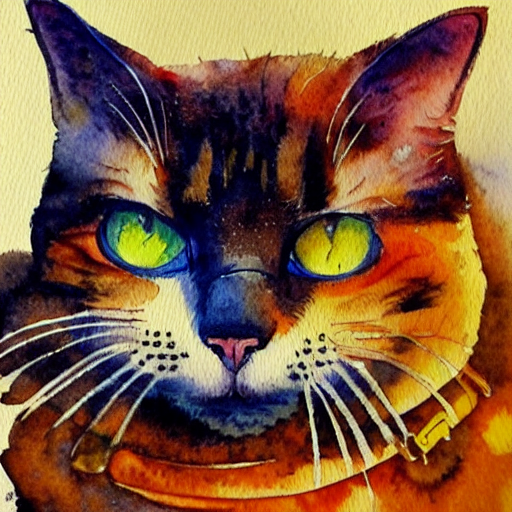

In [ ]:
with autocast("cuda"):
  # i에는 loop index(0번째, 1번째, ..) t에는 현재 timestep
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    latent_model_input = torch.cat([latents] * 2) # CFG를 위해서 2배로
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample

latents = 1 / 0.18215 * latents
with torch.no_grad():
  image = vae.decode(latents).sample # vae가 latent를 image로 변환

image = (image / 2 + 0.5).clamp(0, 1)
# PyTorch 이미지 텐서는 [B, C, H, W] 일반 이미지 배열은 [B, H, W, C]가 더 흔함 그래서 축 순서 바꿈.
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8") # 이미지 라이브러리 표준 형태로 바꿈
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


## The Autoencoder

autoencoder는 image를 latent representation으로 바꾸어주는 역할을 한다.

In [ ]:
def pil_to_latent(input_im):
  with torch.no_grad():
    # unsqueeze(0)는 맨 앞에 차원 하나를 추가해서 배치 차원을 만든다. [3, H, W] → [1, 3, H, W]
    # ToTensor() 의 결괏값 범위는 무조건 [0,1] 이다. vae는 근데 [-1,1] 범위로 받아야하므로 * 2 - 1을 꼭 해준다.
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1)
  return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

4 * 64 * 64 의 latent 이미지를 만듦으로써, 연산횟수를 매우 줄이는 효과가 있다.

한 픽셀마다 los function을 적용하면서 노이즈를 제거해나가면 연산이 어마어마한데, latent space를 통해 연산을 해야할 수를 줄임으로써 효율적인 diffusion이 가능해진다.

In [ ]:
input_image = Image.open("parrot.png").convert("RGB")
input_image = input_image.resize((512, 512))
encoded = pil_to_latent(input_image)
decoded = latents_to_pil(encoded)[0]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## The Scheduler

Diffusion을 진행하면서 매 timestep마다 노이즈를 조금씩 제거해나가야 한다.

스케쥴러는 매 timestep 마다 얼마나 많은 노이즈를 제거해나가야할지 등 디테일을 담당한다.

In [ ]:
scheduler.set_timesteps(15)
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])


15번에 거쳐서 진행하려면 얼마나 노이즈를 빼나가야하는 지 자동으로 계산해서 반영해준다.

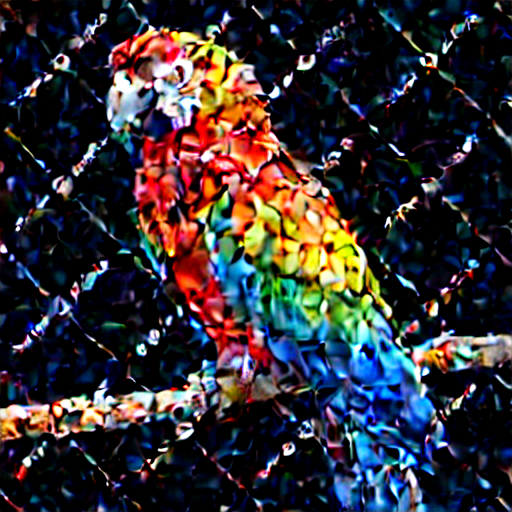

In [ ]:
noise = torch.randn_like(encoded)
sampling_steps = 10
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[sampling_steps]]))
latents_to_pil(encoded_and_noised.float())[0]

내가 입력한 이미지에 sampling step 10번을 거친만큼의 noise를 더해서

latent to pil을 진행하면 노이즈가 가득 섞였지만, 조금 구도는 그대로 유지되어 보이는 이미지가 탄생한다. 이 이미지를 바탕으로 새로운 이미지를 추가하면, img to img의 기본 개념을 구현할 수 있다.

## Loop Starting from noised version of input (img to img)

앞에서 본 것과 동일하게 Diffusion을 진행하되,

첫번쨰 스텝을 위에서 샘플링한 10번째 스텝으로 해서 input image와 구도는 비슷하도록 진행한다.

  0%|          | 0/50 [00:00<?, ?it/s]

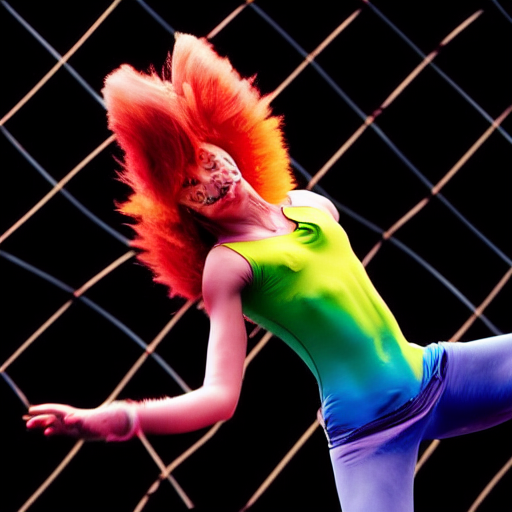

In [ ]:
# Settings (same as before except for the new prompt)
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
set_timesteps(scheduler, num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

input image와 color, structure는 그대로 유지되었지만,
프롬프트를 바탕으로 새로운 이미지가 생성되었다.

이게 img2img가 작동하는 원리이다.



## Exploring the text

In [ ]:
prompt = "a picture of a puppy"

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input["input_ids"][0] # >> 각 token 별 아이디


NameError: name 'tokenizer' is not defined

각 단어마다 tokenizer에서 지정해둔 id가 있다.
puppy는 6829 라는 숫자로 치환된다.

In [ ]:
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
output_embeddings

우리는 token을 text_encoder로 pass해주고, text_encoder는 우리가 model에 넣을 수 있는 숫자값을 계산해서 전달해준다.



### Token Embeddings

In [ ]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer

# 6829번째 행을 look-up해서 puppy의 emb_dim을 모두 구한다.
embedding = token_emb_layer(torch.tensor(6829, device = torch_device))
embedding.shape

# 문장 전체 토큰 IDs를 한 번에 임베딩으로 바꾸기
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
token_embeddings

vocab size = 49408

emb_dim = 768 (한 토큰을 768개의 숫자로 표현)

### Position Embeddings

In [ ]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
position_embeddings

포지션 임베딩(position embedding)은 “토큰이 문장 안에서 몇 번째 위치에 있는지” 정보를 모델에 넣어주는 벡터

### Combining Token and Text

In [ ]:
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
input_embeddings

# 토큰벡터, 포지션 벡터 구하고 더하는 작업을 아래 함수가 한번에 해줌
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

각 토큰의 의미와 위치를 모두 반영해야하기 때문에 두개의 임베딩을 더해주어야 한다.

![transformer diagram](https://github.com/johnowhitaker/tglcourse/raw/main/images/text_encoder_noborder.png)

(1) Multi-head Attention (Self-Attention)
문장 안 토큰들이 서로를 참고하게 함

예: “photo of a puppy”에서 “puppy” 토큰은 “photo”, “of”, “a” 같은 토큰들과 관계를 맺으면서 의미가 더 구체화됨.

(2) Feed-Forward Network (FFN)

각 토큰 벡터를 비선형 변환으로 더 “표현력 있게” 가공해주는 층.

attention으로 섞인 정보를 다시 한 번 깊게 변환

In [ ]:
# 위 그림에서 본 TRANSFORMER BLOCK 역할
# input embeddings에는 위에서 본 token embedding + position embedding이 들어감
def get_output_embeds(input_embeddings):
    bsz, seq_len = input_embeddings.shape[:2] # batch size, token 길이 꺼내기
    # 각 토큰이 서로를 볼 수 있는 지를 제한해주는 mask
    # causal_mask 는 "A photo of puppy" 문장이 있으면 앞 단어 토큰은 뒷 단어 토큰을 못보도록 제한된다.
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None,
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None,
    )

    output = encoder_outputs[0]

    output = text_encoder.text_model.final_layer_norm(output)

    return output

out_embs_test = get_output_embeds(input_embeddings)
print(out_embs_test.shape)
out_embs_test

지금부터 input embedding 중 puppy를 다른 embedding으로 replace 해볼 것이다.

In [ ]:
prompt = "A picture of a puppy"

text_input = tokenizer(prompt, padding = "max_length", max_length = tokenizer.model_max_length, truncation = True, return_tensors = "pt" )
input_ids = text_input.input_ids.to(torch_device)
# token embedding 구하기
token_embeddings = token_emb_layer(input_ids)
# 2368 id의 token embedding vector 꺼내오기
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device = torch_device))
# 6829 token의 인덱스를 torch.where로 찾고, 그 위치를 모두 2368로 replace
token_embeddings[0, torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch.device)

input_embeddings = token_embeddings + position_embeddings

modified_output_embeddings = get_output_embeds(input_embeddings)
modified_output_embeddings

이제 이 modified embedding으로 image를 generate 해보자.

In [ ]:
def generate_with_embs(text_embeddings):
    height = 512
    width = 512
    num_inference_steps = 30
    guidance_scale = 7.5
    generator = torch.manual_seed(32)
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
      # token embedding + position embedding 한번에 뽑아옴
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


In [ ]:
generate_with_embs(modified_output_embeddings)

근데 이걸 왜 했냐?

token을 아예 replace 할 수 있었던 것처럼, token을 mix해서 half-puppy, half 다른거 이렇게 두가지 이미지를 합성한 이미지를 생성할 수 있다.

섞을 때는 position_embedding은 섞지말고 token_embedding 끼리만 섞는다.

In [ ]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# token embedding으로 2가지 종의 동물을 꺼내서, 0.5씩 mix한다.
puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(42194, device=torch_device))
replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate an image with these
generate_with_embs(modified_output_embeddings)